1. Исследовать как лучше кормить данные: попарно или рандомно

## Loaders:

In [1]:
from PIL import Image
import os
import itertools
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
torch.autograd.set_detect_anomaly(True)

BATCH_SIZE = 40
SIZE = [64, 64]
DEVICE = torch.device('cuda:0')
AMOUNT = None

In [2]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, path, resize_params=False, amount=None):
        self.path = path + '/'
        self.items_list = os.listdir(path)[:amount]
        self.len = len(self.items_list)
        
        if resize_params:
            self.resize_params = resize_params
        else:
            self.resize_params = False
        
    def len(self, ):
        return self.len
    
    def __getitem__(self, idx):
        path = self.path + self.items_list[idx]
        with Image.open(path) as file:
            if self.resize_params:
                file = file.resize(self.resize_params)
            item = np.array(file)
            item = torchvision.transforms.ToTensor()(item)
        return item        

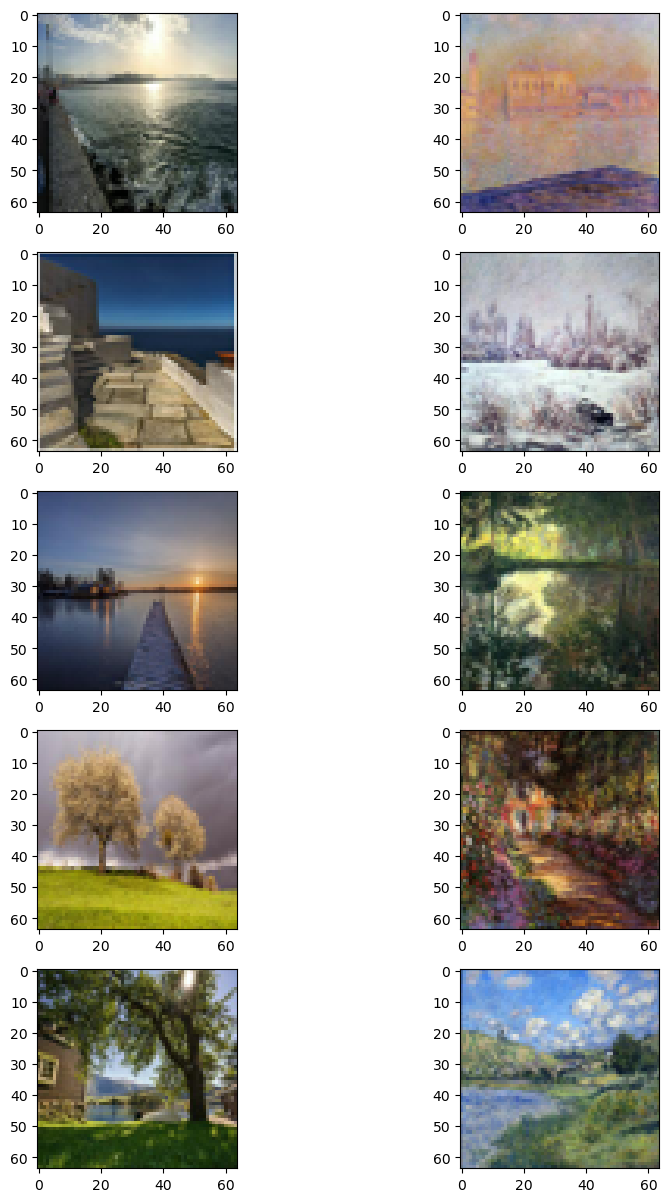

In [3]:
p_dataset = Dataset(path='/home/utisme/dev/cycleStyler/data/monet/photo_jpg', resize_params=SIZE, amount=AMOUNT)
m_dataset = Dataset(path='/home/utisme/dev/cycleStyler/data/monet/monet_jpg', resize_params=SIZE, amount=AMOUNT)
fig, ax = plt.subplots(5, 2, figsize=(10, 15))
for i in range(5):
    ax[i][0].imshow(p_dataset.__getitem__(i).permute(1, 2, 0))
    ax[i][1].imshow(m_dataset.__getitem__(i).permute(1, 2, 0))

In [4]:
def get_loaders(p_dataset, m_dataset, batch_size, ):
    indices = range(p_dataset.len)
    sampler = torch.utils.data.SubsetRandomSampler(indices=indices)
    p_loader = torch.utils.data.DataLoader(p_dataset, batch_size=batch_size, sampler=sampler, drop_last=True)

    indices = range(m_dataset.len)
    sampler = torch.utils.data.SubsetRandomSampler(indices=indices)
    m_loader = torch.utils.data.DataLoader(p_dataset, batch_size=batch_size, sampler=sampler, drop_last=True)

    return p_loader, m_loader
p_loader, m_loader = get_loaders(p_dataset, m_dataset, batch_size=BATCH_SIZE)

## Model:

In [5]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Conv_block, self).__init__()        
        self.conv0 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AvgPool2d(kernel_size=2)
        self.norm = nn.InstanceNorm2d(out_channels)
        
    def forward(self, inputs):
        identity = self.conv0(inputs)
        result = self.conv1(identity)
        result = self.relu(result)
        result = self.norm(result)
        result += identity        
        result = self.pool(result)
        return result
    
class ConvTranspose_block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvTranspose_block, self).__init__()
        self.convT0 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=1)
        self.convT1 = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, stride=2, output_padding=1)
        self.relu = nn.ReLU()
        self.norm = nn.InstanceNorm2d(out_channels)
        
    def forward(self, inputs):
        result = self.convT0(inputs)
        result += inputs
        result = self.convT1(result)
        result = self.relu(result)
        result = self.norm(result)
        return result
    

class Generator(nn.Module):
    def __init__(self, ):
        super(Generator, self).__init__()
        self.conv0 = Conv_block(in_channels=3, out_channels=64)
        self.conv1 = Conv_block(in_channels=64, out_channels=128)
        self.conv2 = Conv_block(in_channels=128, out_channels=256)
        self.conv3 = Conv_block(in_channels=256, out_channels=512)
        self.conv4 = Conv_block(in_channels=512, out_channels=512)
        
        self.convT0 = ConvTranspose_block(in_channels=512, out_channels=512)
        self.convT1 = ConvTranspose_block(in_channels=512, out_channels=256)
        self.convT2 = ConvTranspose_block(in_channels=256, out_channels=128)
        self.convT3 = ConvTranspose_block(in_channels=128, out_channels=64)
        self.convT4 = ConvTranspose_block(in_channels=64, out_channels=3)
        self.sigmoid = torch.nn.Sigmoid()
        print('Кол-во параметров: ', sum([param.numel() for param in self.parameters()]))
        
        
    def forward(self, inputs):
        result = self.conv0(inputs)
        result = self.conv1(result)
        result = self.conv2(result)
        result = self.conv3(result)
        result = self.conv4(result)
        
        result = self.convT0(result)
        result = self.convT1(result)
        result = self.convT2(result)
        result = self.convT3(result)
        result = self.convT4(result)
        result = self.sigmoid(result)
        return result

    def load(self, direction):
        self.load_state_dict(torch.load(direction)())
    
class Discriminator(nn.Module):
    def __init__(self, size, batch_size):
        super(Discriminator, self).__init__()
        self.conv0 = Conv_block(in_channels=3, out_channels=64)
        self.conv1 = Conv_block(in_channels=64, out_channels=128)
        self.conv2 = Conv_block(in_channels=128, out_channels=256)
        self.conv3 = Conv_block(in_channels=256, out_channels=512)
        
        flatten = int((size[0] / 2**4) * (size[1] / 2**4) * 512)
        self.fc = nn.Linear(flatten, 1)
        print('Кол-во параметров: ', sum([param.numel() for param in self.parameters()]))
        
        self.batch_size = batch_size
        
        
    
    def forward(self, inputs):
        result = self.conv0(inputs)
        result = self.conv1(result)
        result = self.conv2(result)
        result = self.conv3(result)
        result = result.view(self.batch_size, -1)
        result = self.fc(result)
        return result

    def load(self, direction):
        self.load_state_dict(torch.load(direction)())
        

## Training:

In [6]:
def checkpoint(models, optims, direction, epoch):
    for number, model in enumerate(models):
        torch.save(model.state_dict, direction + f'{number}_{epoch}m')
    for number, optim in enumerate(optims):
        torch.save(optim.state_dict, direction + f'{number}_{epoch}o')      
                   
def train(d2_loader,
          d2_gen,
          d2_disc,
          d1_loader,
          d1_gen,
          d1_disc,
          loss_fn,
          generators_optim,
          discriminators_optim,
          device,
          epochs=1):
    """
    name logic: d1  _  estim  _  fake
                 ^       ^         ^
              target    type    attitude
              domain
    
    
    ::: - d1_loader must be equal or bigger than d2_loader
    
    """
    
    d2_gen.to(device)
    d2_gen.train()
    d1_gen.to(device)
    d2_gen.train()
    d2_disc.to(device)
    d2_disc.train()
    d1_disc.to(device)
    d1_disc.train()
    
    for epoch in range(0, epochs):
        print('Epoch', str(epoch) + '/' + str(epochs), ': <', end='')
        start_time = time.time()
        
        for iteration, d1_pic_real in enumerate(d1_loader):
            d2_pic_real = next(iter(d2_loader))
            
            d1_pic_real = d1_pic_real.to(device)
            d2_pic_real = d2_pic_real.to(device)

        # CALCS:
          # cycle 1:
            d2_pic_fake = d2_gen(d1_pic_real)
            d1_pic_cycled = d1_gen(d2_pic_fake)
          # cycle 2:
            d1_pic_fake = d1_gen(d2_pic_real)
            d2_pic_cycled = d2_gen(d1_pic_fake)

          # selfsame generations:
            d2_pic_same = d2_gen(d2_pic_real)
            d1_pic_same = d1_gen(d1_pic_real)

          # discriminator estimates:
            d2_estim_real = d2_disc(d2_pic_real)
            d1_estim_real = d1_disc(d1_pic_real)
            d2_estim_fake_gen = d2_disc(d2_pic_fake)   # using for generator grads
            d1_estim_fake_gen = d1_disc(d1_pic_fake)
            d2_estim_fake_disc = d2_disc(d2_pic_fake.detach())  # using for discriminator grads
            d1_estim_fake_disc = d1_disc(d1_pic_fake.detach())

        # LOSSES:
          # cycled losses:
            d2_loss_cycled = loss_fn(d2_pic_cycled, d2_pic_real)
            d1_loss_cycled = loss_fn(d1_pic_cycled, d1_pic_real)
            total_loss_cycled = d1_loss_cycled + d2_loss_cycled

          # selfsame losses:
            d2_loss_same = loss_fn(d2_pic_same, d2_pic_real)
            d1_loss_same = loss_fn(d1_pic_same, d1_pic_real)

          # generator losses:
            d2_loss_gen = loss_fn(d2_estim_fake_gen, torch.ones_like(d2_estim_fake_gen))
            d1_loss_gen = loss_fn(d1_estim_fake_gen, torch.ones_like(d2_estim_fake_gen))
            d1d2_loss_gen_total = total_loss_cycled + d2_loss_gen + d2_loss_same + d1_loss_gen + d1_loss_same

          # disc losses:
            d2_loss_disc_real = loss_fn(d2_estim_real, torch.ones_like(d2_estim_real))
            d2_loss_disc_fake = loss_fn(d2_estim_fake_disc, torch.ones_like(d2_estim_fake_disc))
            d2_loss_disc_total = d2_loss_disc_real + d2_loss_disc_fake
            d1_loss_disc_real = loss_fn(d1_estim_real, torch.ones_like(d1_estim_real))
            d1_loss_disc_fake = loss_fn(d1_estim_fake_disc, torch.zeros_like(d1_estim_fake_disc))
            d1_loss_disc_total = d1_loss_disc_real + d1_loss_disc_fake

        # OPTIMIZATION:
          # generator:
            generators_optim.zero_grad()
            d1d2_loss_gen_total.backward()
            generators_optim.step()

          # discriminator:
            discriminators_optim.zero_grad()
            d2_loss_disc_total.backward()
            d1_loss_disc_total.backward()
            discriminators_optim.step()
            
            if not iteration % 10:
                print('=', end='')
        print('>| time = ', round(time.time() - start_time), 's')
        
            
        if not epoch % 5:
            with torch.no_grad():
                fig, ax = plt.subplots(1, 2)
                d2_sample_fake = d2_pic_fake[0].permute(1, 2, 0).detach().to('cpu')
                ax[0].imshow(d2_sample_fake)
                d1_sample_real = d1_pic_real[0].permute(1, 2, 0).detach().to('cpu')
                ax[1].imshow(d1_sample_real)
                plt.show()
            checkpoint([d2_gen, d1_gen, d2_disc, d1_disc],
                        [generators_optim, discriminators_optim],
                        direction='checkpoints/',
                        epoch=epoch)
        
            
        

In [7]:
d2_gen = Generator().to(DEVICE)
d1_gen = Generator().to(DEVICE)
d2_disc = Discriminator(size=SIZE, batch_size=BATCH_SIZE).to(DEVICE)
d1_disc = Discriminator(size=SIZE, batch_size=BATCH_SIZE).to(DEVICE)
loss_fn = torch.nn.MSELoss()
generators_optim = torch.optim.Adam(itertools.chain(d2_gen.parameters(), d1_gen.parameters()))
discriminators_optim = torch.optim.Adam(itertools.chain(d2_disc.parameters(), d1_disc.parameters()))

Кол-во параметров:  18809475
Кол-во параметров:  18809475
Кол-во параметров:  4693569
Кол-во параметров:  4693569


In [8]:
load_epoch = 0
d2_gen.load(f'checkpoints/0_{load_epoch}m')
d1_gen.load(f'checkpoints/1_{load_epoch}m')
d2_disc.load(f'checkpoints/2_{load_epoch}m')
d1_disc.load(f'checkpoints/3_{load_epoch}m')
generators_optim.load_state_dict(torch.load(f'checkpoints/0_{load_epoch}o')())
discriminators_optim.load_state_dict(torch.load(f'checkpoints/1_{load_epoch}o')())

Epoch 0/110 : <==================>| time =  160 s


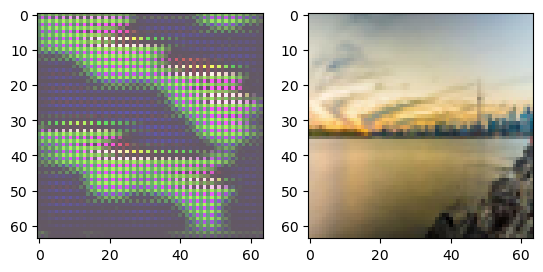

Epoch 1/110 : <==================>| time =  156 s
Epoch 2/110 : <==================>| time =  158 s
Epoch 3/110 : <==================>| time =  169 s
Epoch 4/110 : <==================>| time =  152 s
Epoch 5/110 : <==================>| time =  150 s


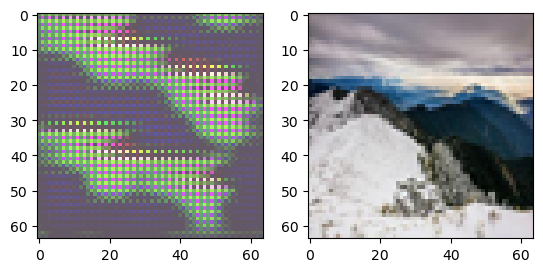

Epoch 6/110 : <==================>| time =  150 s
Epoch 7/110 : <==================>| time =  150 s
Epoch 8/110 : <==================>| time =  150 s
Epoch 9/110 : <==================>| time =  150 s
Epoch 10/110 : <==================>| time =  150 s


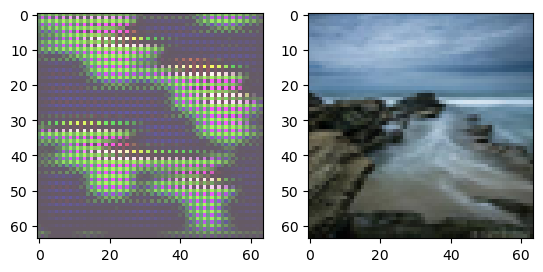

Epoch 11/110 : <==================>| time =  150 s
Epoch 12/110 : <==================>| time =  150 s
Epoch 13/110 : <==================>| time =  150 s
Epoch 14/110 : <==================>| time =  150 s
Epoch 15/110 : <==================>| time =  150 s


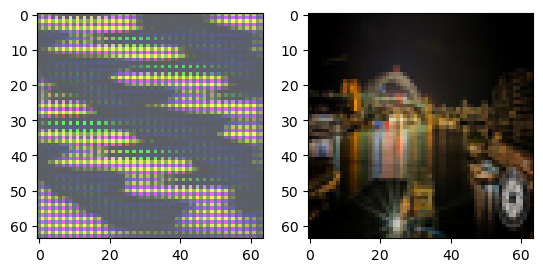

Epoch 16/110 : <==================>| time =  150 s
Epoch 17/110 : <==================>| time =  150 s
Epoch 18/110 : <==================>| time =  150 s
Epoch 19/110 : <==================>| time =  150 s
Epoch 20/110 : <==================>| time =  150 s


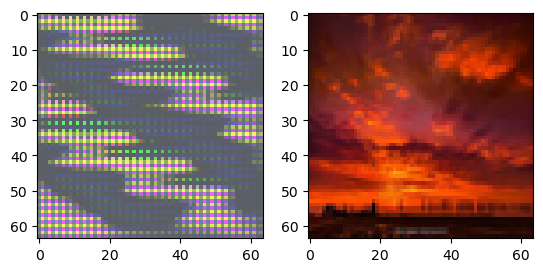

Epoch 21/110 : <==================>| time =  150 s
Epoch 22/110 : <==================>| time =  150 s
Epoch 23/110 : <==================>| time =  150 s
Epoch 24/110 : <==================>| time =  150 s
Epoch 25/110 : <==================>| time =  150 s


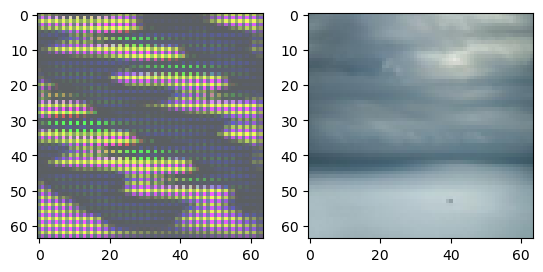

Epoch 26/110 : <==================>| time =  150 s
Epoch 27/110 : <==================>| time =  150 s
Epoch 28/110 : <==================>| time =  150 s
Epoch 29/110 : <==================>| time =  150 s
Epoch 30/110 : <==================>| time =  150 s


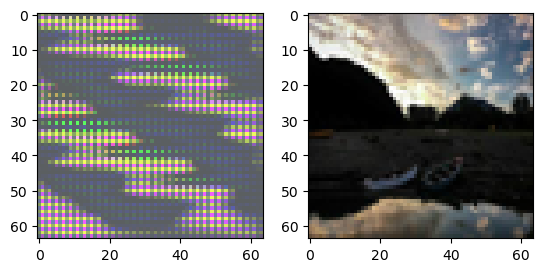

Epoch 31/110 : <==================>| time =  150 s
Epoch 32/110 : <==================>| time =  150 s
Epoch 33/110 : <==================>| time =  150 s
Epoch 34/110 : <==================>| time =  150 s
Epoch 35/110 : <==================>| time =  150 s


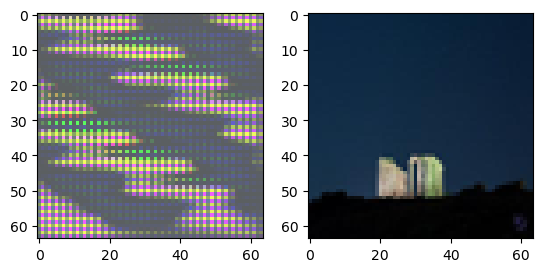

Epoch 36/110 : <==================>| time =  150 s
Epoch 37/110 : <==================>| time =  150 s
Epoch 38/110 : <==================>| time =  150 s
Epoch 39/110 : <==================>| time =  150 s
Epoch 40/110 : <==================>| time =  150 s


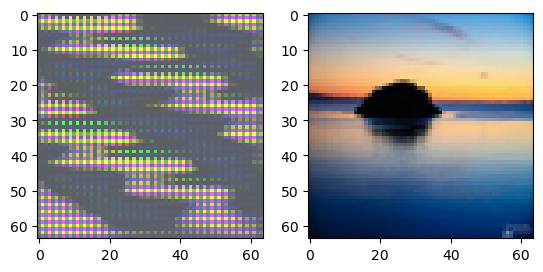

Epoch 41/110 : <==================>| time =  158 s
Epoch 42/110 : <==================>| time =  151 s
Epoch 43/110 : <==================>| time =  151 s
Epoch 44/110 : <==================>| time =  151 s
Epoch 45/110 : <==================>| time =  152 s


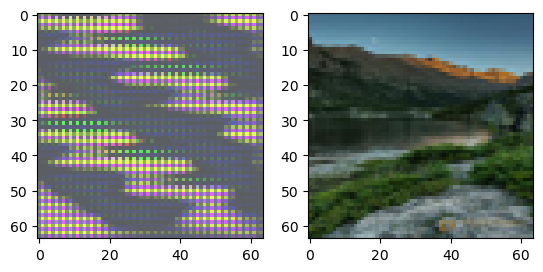

Epoch 46/110 : <==================>| time =  154 s
Epoch 47/110 : <==================>| time =  154 s
Epoch 48/110 : <==================>| time =  156 s
Epoch 49/110 : <==================>| time =  157 s
Epoch 50/110 : <========

In [ ]:
train(m_loader,
      d2_gen,
      d2_disc,
      p_loader,
      d1_gen,
      d1_disc,
      loss_fn,
      generators_optim,
      discriminators_optim,
      device = DEVICE,
      epochs=110)